### Instantiate Transformer using only `numpy, torch`

In [1]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(self, embedding_size, src_vocab_size, trg_vocab_size, src_pad_idx, num_heads, num_encoder_layers, num_decoder_layers, forward_expansion, dropout, max_len):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = "cpu"
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)

        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out


/home/rilab/.pyenv/versions/3.8.13/envs/llm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Example

In [23]:
import matplotlib.pyplot as plt
import torch

# Example usage of Transformer model
embedding_size = 128
src_vocab_size = 100
trg_vocab_size = 100
src_pad_idx = 1
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len = 100
forward_expansion = 4

model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len
)

src = torch.LongTensor([[1,5,6,4,3,9,5,2], [1,8,7,3,4,6,7,2]]).to(model.device)
trg = torch.LongTensor([[1,7,4,3,5,9,2,6], [1,5,6,2,4,7,2,3]]).to(model.device)

out = model.forward(src, trg)

print(out.shape)  # (trg_seq_length, batch_size, output_dim)


torch.Size([2, 8, 100])


/tmp/ipykernel_200475/2631954653.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_model = torch.tensor(d_model).int()


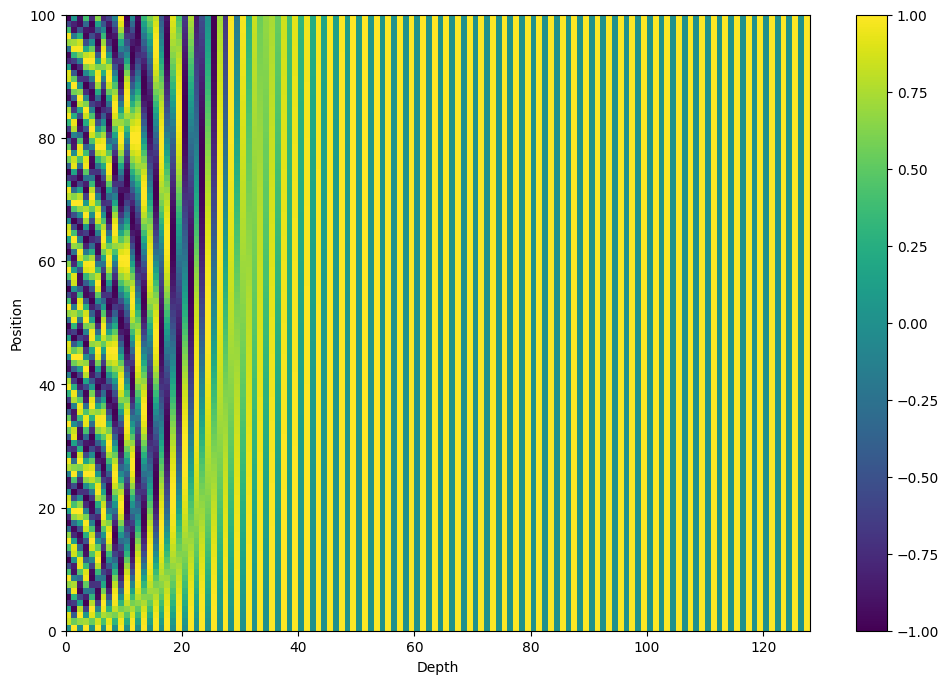

In [24]:
# Example plot of positional encoding
def get_positional_encoding(max_len, d_model):
    PE = torch.zeros(max_len, d_model)
    for pos in range(max_len):
        pos = torch.tensor(pos).long()
        d_model = torch.tensor(d_model).int()
        for i in range(0, d_model, 2):
            PE[pos, i] = torch.sin(pos / (10000 ** ((2 * i) / d_model)))
            if i + 1 < d_model:
                PE[pos, i + 1] = torch.cos(pos / (10000 ** ((2 * i) / d_model)))
    return PE

positional_encoding = get_positional_encoding(max_len, embedding_size)

plt.figure(figsize=(12,8))
plt.pcolormesh(positional_encoding, cmap='viridis')
plt.xlabel('Depth')
plt.xlim((0, embedding_size))
plt.ylabel('Position')
plt.colorbar()
plt.show()
